In [1]:
import pickle
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import matplotlib.mlab as mlab
import math

# Main goal: 
Fit a model for multisensory localization as a weighted average of visual and auditory information in a first round of experiments, then test it in a second round of experiment. The underlying assumption is that the mulitmodal localization can be modelled as some weighted average of the purely auditory/visual inputs via:

$$ L^* = w_v L^*_v +  w_a L^*_a  $$

where 
$w_v, w_a$  are the weights for the auditory/visual input, 
$L^*_w, L^*_a$ are the location estimates based on the purely visual/auditory input and 
$L^*$ is the location estimate based on the combined input.

## First round of experiments: purely visual & purely auditory
__Goals__:
- estimate weights $w_a, w_v$ for the auditory and visual information in the model of the multisensory setup
- find location estimates $L_a^*, L_v^*$ based on the purely auditory/visual inputs 

__Method__:
This will be achieved via  fitting a cumulative normal distribution to fit the datapoints we see - using the method of *Maximum Likelihood Estimation* (MLE). Recall that a normal distribution is defined by it's variance $\sigma^2$ and it's mean $\mu$. We thus want to estimate 

$$ \widehat{\sigma}^2, \widehat{\mu} = argmax_{\mu, \sigma} \prod_{t=1}^{T} p_t^{r_t} (1-p_t)^{1-r_t}
= argmax_{\mu, \sigma} \prod_{t=1}^{T} (\frac{1}{2}(1+erf(\frac{x-\mu}{\sqrt(2\sigma^2)})) )^{r_t} (1-(1+erf(\frac{x-\mu}{\sqrt(2\sigma^2)})))^{1-r_t}
$$

*TODO: annoying work of explaining all the variables and why a Bernoulli probability is the right choice*

Battaglia et al. suggested the following modification to the "classical MLE" model: transform it into a Bayesian model by adding priors $p(\sigma)$ and $p(\mu)$. The reason is the (evolutionary?) bias towards visual input as a more reliable source that the MLE model doesn't capture. In fact, some authors claim that this visual dominance is even so strong that the visual sensory input will completely dominate the auditory one (*visual capture theroy*). We thus refine our model into 



$$ \widehat{\sigma}^2, \widehat{\mu} = argmax_{\mu, \sigma} \prod_{t=1}^{T} (\frac{1}{2}(1-erf(\frac{x-\mu}{\sqrt(2\sigma^2)})) )^{r_t} (1-(1-erf(\frac{x-\mu}{\sqrt(2\sigma^2)})))^{1-r_t} \cdot p_{\sigma^2}(\sigma^2) \cdot p_{\mu}(\mu)$$

The prior for $\mu$ is just a uniform distribution. More interestingly, the prior for $\sigma^2$ is an *inverse gamma distribution* that we model in a way that it favors small variances (corresponding to __reliable__ sensory input) 
[*TODO: explain why and how this is, write out mathzzz*].

needed python functionalities:
    - argmax / maximum likelihood
    - inverse gamma distribution
    - uniform distribution
    
possibly useful:
    - stats.bernoulli

In [48]:
from scipy import stats, optimize
from math import erf, sqrt, exp

In [78]:
def phi(x, mu, sigma2):
    # rewrote it to take sigma2 and then take the square root - not sure this is numerically smart... try without
    sigma = math.sqrt(sigma2)
    distribution = stats.norm(loc = mu, scale = sigma)
    #print('Phi gives %s for params %s, %s' %(distribution.cdf(x), mu, sigma2))
    
    return distribution.cdf(x)

In [51]:
def round1_log_likelihood_audio(degrees, answers, mu, sigma2):
# likelihood(R|mu, sigma) = 
    likelihood = 0
    # model the product
    for t in range(len(degrees)):
        # do we want the loc=0 here?
        if stats.bernoulli.pmf(answers[t], phi(degrees[t], mu, sigma2)) <= 0:
            print('LOG OF X SMALLER THAN 0', answers[t], phi(degrees[t], mu, sigma2))
            likelihood += float('-inf')
            continue
        likelihood = likelihood + math.log(stats.bernoulli.pmf(answers[t], phi(degrees[t], mu, sigma2)))

    return likelihood

In [52]:
# get the weights from the sigmas we calculated
def get_weight_from_variance(variance, other_variance):
    return (1/variance)/((1/variance + 1/other_variance))

wfv_vectorized = np.vectorize(get_weight_from_variance)

### Apply to our data - aggregated over all audio results - NOOOO

In [24]:
import itertools

In [25]:
# TODO: aggregate over all audio results and check then 
audio_aggegrated = []
for filename in os.listdir('data/preprocessed/audio'):
    if filename.endswith('.p'):
        number = int(filename[11:-2])
        if number > 4:
            audio_aggegrated.append(pickle.load( open('data/preprocessed/audio/' + filename, "rb" )))
            print(filename)
            print(len(audio_aggegrated))

participant10.p
1
participant11.p
2
participant12.p
3
participant13.p
4
participant14.p
5
participant15.p
6
participant16.p
7
participant17.p
8
participant18.p
9
participant20.p
10
participant5.p
11
participant6.p
12
participant7.p
13
participant8.p
14
participant9.p
15


In [84]:
locations = []
answers = []
for result in audio_aggegrated:
    locations.append(result[0])
    answers.append(result[1])

In [85]:
locations = list(itertools.chain(*locations))
answers = list(itertools.chain(*answers))

In [87]:
aggregated_data = np.array([locations, answers])
results = compute_MLE_1(aggregated_data, True)

LOG OF X SMALLER THAN 0 0.0 1.0
LOG OF X SMALLER THAN 0 1.0 0.0
LOG OF X SMALLER THAN 0 0.0 1.0
LOG OF X SMALLER THAN 0 0.0 1.0
LOG OF X SMALLER THAN 0 1.0 0.0
LOG OF X SMALLER THAN 0 0.0 1.0
LOG OF X SMALLER THAN 0 0.0 1.0
LOG OF X SMALLER THAN 0 0.0 1.0
LOG OF X SMALLER THAN 0 0.0 1.0
LOG OF X SMALLER THAN 0 0.0 1.0
LOG OF X SMALLER THAN 0 0.0 1.0
LOG OF X SMALLER THAN 0 0.0 1.0
LOG OF X SMALLER THAN 0 0.0 1.0
LOG OF X SMALLER THAN 0 0.0 1.0
LOG OF X SMALLER THAN 0 1.0 0.0
LOG OF X SMALLER THAN 0 0.0 1.0
LOG OF X SMALLER THAN 0 0.0 1.0
LOG OF X SMALLER THAN 0 0.0 1.0
LOG OF X SMALLER THAN 0 0.0 1.0
LOG OF X SMALLER THAN 0 0.0 1.0
LOG OF X SMALLER THAN 0 0.0 1.0
LOG OF X SMALLER THAN 0 0.0 1.0
LOG OF X SMALLER THAN 0 1.0 0.0
LOG OF X SMALLER THAN 0 1.0 0.0
LOG OF X SMALLER THAN 0 1.0 0.0
LOG OF X SMALLER THAN 0 1.0 0.0
LOG OF X SMALLER THAN 0 0.0 1.0
LOG OF X SMALLER THAN 0 0.0 1.0
LOG OF X SMALLER THAN 0 1.0 0.0
LOG OF X SMALLER THAN 0 1.0 0.0
LOG OF X SMALLER THAN 0 1.0 0.0
LOG OF X

KeyboardInterrupt: 

In [42]:
final_audio_mu = results['mu']
final_audio_sigma2 = results['sigma2'] 
print(final_audio_mu, final_audio_sigma2)

1.33341949049 4.33447914774


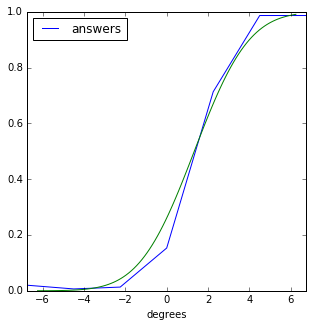

In [43]:
fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot(111)
data_frame = pd.DataFrame(aggregated_data).T
data_frame.columns = ['degrees', 'answers']
points = data_frame.groupby('degrees').mean()
points.plot(ax = ax)
x = np.linspace(-6.25, 6.25, 100)
ax.plot(x,phi(x, results['mu'], results['sigma2']))
plt.show()

### - aggregated over all video results

In [26]:
from collections import defaultdict

In [82]:
math.sqrt(1e-8)

0.0001

In [ ]:
def phi(x, mu, sigma2):
    # rewrote it to take sigma2 and then take the square root - not sure this is numerically smart... try without
    sigma = math.sqrt(sigma2)
    distribution = stats.norm(loc = mu, scale = sigma)
    #print('Phi gives %s for params %s, %s' %(distribution.cdf(x), mu, sigma2))
    
    return distribution.cdf(x)

In [53]:
# BAYESIAN ADJUSTED METHOD
def round1_log_likelihood_video(degrees, answers, mu, sigma2):
    likelihood = 0
    for t in range(len(degrees)):
        # do we want the loc=0 here?
        if stats.bernoulli.pmf(answers[t], phi(degrees[t], mu, sigma2))* igdistr.pdf(sigma2)   <= 0:
            print('LOG OF X SMALLER THAN 0', 'answer:', answers[t], 'prob:', phi(degrees[t], mu, sigma2),
                 'invg:', igdistr.pdf(sigma2))
            return float('-inf')
            #continue
        likelihood = likelihood + math.log(stats.bernoulli.pmf(
                answers[t], phi(degrees[t], mu, sigma2))* igdistr.pdf(sigma2))

    return likelihood

In [72]:
# methods that support passing bounds = 'TNC','L-BFGS-B', 'SLSQP'
def compute_MLE_1(data, audio):
    degrees = data[0, :]
    answers = data[1, :]
    if audio:
        result = optimize.minimize(lambda x: -round1_log_likelihood_audio(degrees, answers, *x), x0 = [1.125,0.0001] , 
                                   tol = 1e-3, method = 'TNC' , bounds = [(-6.26, 6.25),(1e-36, None)], 
                                   options={'disp': False, 'iprint': 1, 'eps': 1.4901161193847656e-03, 
                                            'maxiter': 20, 'ftol': 1e-05})
    
    else:
        result = optimize.minimize(lambda x: -round1_log_likelihood_video(degrees, answers, *x), x0 = [1.125,6e-7] , 
                                   tol = 1e-11, method = 'TNC' , bounds = [(-6.26, 6.25),(1e-12, 1)], 
                                   options={'disp': True, 'iprint': 1})
                                            
                                            #, 'eps': 1.4901161193847656e-03, 
                                            #'maxiter': 20, 'ftol': 1e-03})
    print(result)
    mu = result['x'][0]
    sigma2 = result['x'][1]
    return {'mu':mu, 'sigma2':sigma2}

In [73]:
video_all = []
for filename in os.listdir('data/preprocessed/video'):
    if filename.endswith('.p'):
        number = int(filename[11:-2])
        if number > 4:
            video_all.append(pickle.load( open('data/preprocessed/video/' + filename, "rb" )))
            #print(filename)
            #print(len(video_aggegrated))

In [79]:
sigma_mus = list()
for result in video_all:
    for noise in result.keys():
        locations_here = result[noise][0] 
        answers_here = result[noise][1]
        data = np.array([locations_here, answers_here])
        sigma_mu = compute_MLE_1(data, audio=False)
                                 #=False)
        sigma_mus.append(sigma_mu)

/Users/polaschwoebel/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: OptimizeWarning: Unknown solver options: iprint


LOG OF X SMALLER THAN 0 1.0 0.0
LOG OF X SMALLER THAN 0 1.0 0.0
LOG OF X SMALLER THAN 0 1.0 0.0
LOG OF X SMALLER THAN 0 0.0 1.0
LOG OF X SMALLER THAN 0 1.0 0.0
LOG OF X SMALLER THAN 0 1.0 0.0
LOG OF X SMALLER THAN 0 1.0 0.0
LOG OF X SMALLER THAN 0 1.0 0.0
LOG OF X SMALLER THAN 0 0.0 1.0
LOG OF X SMALLER THAN 0 1.0 0.0
LOG OF X SMALLER THAN 0 1.0 0.0
LOG OF X SMALLER THAN 0 1.0 0.0
LOG OF X SMALLER THAN 0 1.0 0.0
LOG OF X SMALLER THAN 0 0.0 1.0
LOG OF X SMALLER THAN 0 1.0 0.0
LOG OF X SMALLER THAN 0 0.0 1.0
LOG OF X SMALLER THAN 0 1.0 0.0
LOG OF X SMALLER THAN 0 1.0 0.0
LOG OF X SMALLER THAN 0 1.0 0.0
LOG OF X SMALLER THAN 0 1.0 0.0
LOG OF X SMALLER THAN 0 0.0 1.0
LOG OF X SMALLER THAN 0 1.0 0.0
LOG OF X SMALLER THAN 0 1.0 0.0
LOG OF X SMALLER THAN 0 1.0 0.0
LOG OF X SMALLER THAN 0 1.0 0.0
LOG OF X SMALLER THAN 0 0.0 1.0
LOG OF X SMALLER THAN 0 1.0 0.0
LOG OF X SMALLER THAN 0 1.0 0.0
LOG OF X SMALLER THAN 0 1.0 0.0
LOG OF X SMALLER THAN 0 1.0 0.0
LOG OF X SMALLER THAN 0 0.0 1.0
LOG OF X

KeyboardInterrupt: 

In [60]:
# aggregated version
all_results_video = defaultdict(list)
for result in video_aggegrated:
    for key in result.keys():
        all_results_video[key].append(result[key])

In [75]:
sigma_mus = defaultdict(dict)
for noise in all_results_video.keys():
    locations_here = [res[0] for res in all_results_video[noise]]
    answers_here = [res[1] for res in all_results_video[noise]]
    all_results_video[noise] = (list(itertools.chain(*locations_here)), list(itertools.chain(*answers_here)))
    aggregated_data = np.array(all_results_video[noise])
    results = compute_MLE_1(aggregated_data, audio=True)
                            #False)
    sigma_mus[noise]= results

TypeError: 'numpy.float64' object is not iterable

In [123]:
sigma_mus

defaultdict(dict, {})

In [124]:
final_video_results = pd.DataFrame(sigma_mus).T
final_video_results

""


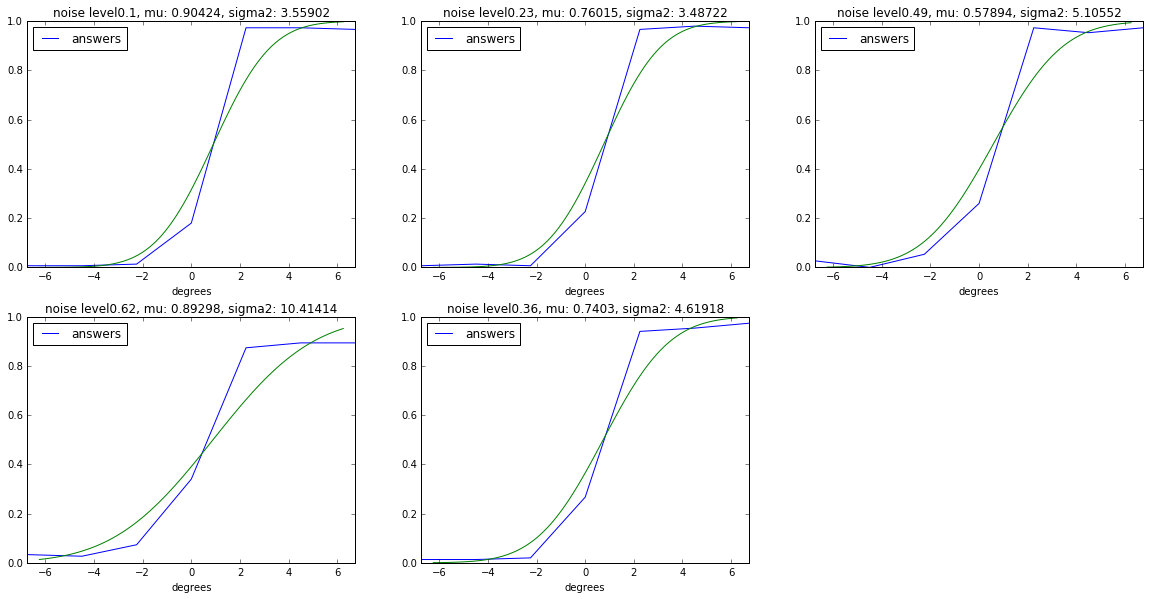

In [88]:
#graph the data points and the fitted distributions
fig = plt.figure(figsize = (20, 15))
for i, noise in enumerate(all_results_video.keys()):
        ax = fig.add_subplot(3,3, i+1)
        name = 'noise level' + str(noise) 
        # plot the real datapoints
        data = all_results_video[noise]
        data_frame = pd.DataFrame(np.array(data)).T
        data_frame.columns = ['degrees', 'answers']
        points = data_frame.groupby('degrees').mean()
        points.plot(ax = ax)
        
        mu = sigma_mus[noise]['mu']
        sigma2 = sigma_mus[noise]['sigma2']
        ax.title.set_text(str(name) + ', mu: ' + str(round(mu, 5)) + ', sigma2: ' + str(round(sigma2, 5)))
        # plot the fitted cumulative normal distribution
        x = np.linspace(-6.25, 6.25, 100)
        ax.plot(x,phi(x, mu, sigma2))
plt.show()  

In [158]:
final_video_results['visual_weights'] = wfv_vectorized(final_video_results['sigma2'].as_matrix(), np.repeat(final_audio_sigma2,5))
final_video_results['sigma2_audio'] = final_audio_sigma2

final_video_results

,mu,sigma2,visual_weights,sigma2_audio
0.10,0.904236,3.559024,0.549090,4.333964
0.23,0.760145,3.487219,0.554132,4.333964
0.36,0.740301,4.619183,0.484072,4.333964
0.49,0.578939,5.105518,0.459132,4.333964
0.62,0.892976,10.414142,0.293866,4.333964


## Second round of experiments:
Compare the weights obtained in the second experiment (and thus the model for multisensory integration) and compare it with empirical results. The empirical weights are again found via a maximum likelihood estimation similar to the monosensory trials, but with a modified probability $p_t$:
\begin{align}
\widehat{w}_a, \widehat{w}_v &= argmax_{w_a, w_v} \prod_{t=1}^{T} p_t^{r_t} (1-p_t)^{1-r_t} \\
&= argmax_{w_a, w_v} \prod_{t=1}^{T} (\frac{1}{1 + exp[-(L_c - L_s)/\tau]})^{r_t} (1-(\frac{1}{1 + exp[-(L_c - L_s)/\tau])}^{1-r_t}) \\
&= argmax_{w_a, w_v} \prod_{t=1}^{T} (\frac{1}{1 + exp[-(w_vL_v^c + w_aL_a^c - (w_vL_v^s + w_aL_a^s))/\tau]})^{r_t} (1-(\frac{1}{1 + exp[-(w_vL_v^c + w_aL_a^c - (w_vL_v^s + w_aL_a^s)))/\tau])}^{1-r_t})
\end{align}

*NOTE: I am still ab bit confused about their explanation with 'location estimates' here. I think we probably just have to use the actual locations because we don't really have any location estimates other than the mean of the two distributions fitted in the first round which should just be very close to zero. Is this just a mistake in the paper?
Related question: the visual and audio location is the same in the comparison stimulus then, right? Then L_c collapses  (since the weights sum to 1) Also it makes no sense to optimize for both of the weights since they are constrained to sum to one.*
With these assumptions the equation would simplify to 

$$
argmax_{w_a, w_v} \prod_{t=1}^{T} (\frac{1}{1 + exp[-(L_c - (w_vL_v^s + (1-w_v)L_a^s))/\tau]})^{r_t} (1-(\frac{1}{1 + exp[-(L_c - (w_vL_v^s + (1-w_v)L_a^s)))/\tau])}^{1-r_t}).
$$

In [147]:
def logistic_prob(degree, w_v, tau, noise_level):
    l_s_a = final_audio_mu
    l_s_v = sigma_mus[noise_level]['mu']
    #print((w_v*l_s_v + (1-w_v)*l_s_a)/tau)
    return 1 / (1 + exp(- (degree - (w_v*l_s_v + (1-w_v)*l_s_a))/tau))

In [136]:
# rewrite w_a = 1 - w_v
def round2_likelihood(degrees, answers, w_v, tau):
    l_s_a = 2.25
    l_s_v = -2.25
    # adjusted paper locations to our 7-location setting - is this CORRECT?
    likelihood = 1
    # model the product
    for t in range(len(degrees)):
        #likelihood = (likelihood * 1 / (1 + exp(- (L[t] - w_v*l_s_v + w_a*l_s_a))/tau)**answers[t] 
        #                        * ( 1 - 1 / (1 + exp(- (L[t] - w_v*l_s_v + w_a*l_s_a))/tau))**(1 - answers[t]))
        # rewrite w_a = 1 - w_v
        likelihood = likelihood * (1 / (1 + exp(- (degrees[t] - (w_v*l_s_v + (1-w_v)*l_s_a))/tau))**answers[t] 
                                * ( 1 - (1 / (1 + exp(- (degrees[t] - w_v*l_s_v + (1-w_v)*l_s_a))/tau)))**(1 - answers[t]))
    return likelihood

In [137]:
# rewrite w_a = 1 - w_v
def round2_log_likelihood_wlocations(degrees, answers, w_v, tau, noise_level):
    # adjusted paper locations to our 7-location setting - is this CORRECT?
    likelihood = 0
    # model the sum
    for t in range(len(degrees)):
        if stats.bernoulli.pmf(answers[t], logistic_prob(degrees[t], w_v, tau, noise_level)) <= 0:
            log = float('-inf')
        else:
            log = math.log(stats.bernoulli.pmf(answers[t], logistic_prob(degrees[t], w_v, tau, noise_level)))
        likelihood += log
        #print(likelihood)
    return likelihood

In [138]:
def compute_MLE_2(data):
    degrees = data[0, :]
    print(degrees)
    answers = data[1, :]
    print(answers)
    result = optimize.minimize(lambda x: -round2_log_likelihood(degrees, answers, *x), 
                               [0.200000, 1.000000], method = 'TNC' , bounds = [(0, 1),(1e-5, None)], tol =1e-5)['x']
    w_v = result[0]
    tau = result[1]
    return {'w_v':w_v, 'tau':tau}

In [172]:
def compute_MLE_2_wlocations(data, noise_level):
    degrees = data[0, :]
    print(degrees)
    answers = data[1, :]
    print(answers)
    result = optimize.minimize(lambda x: -round2_log_likelihood_wlocations(degrees, answers, *x, noise_level), 
                               [0.500000, 1.000000], method = 'TNC' , bounds = [(0, 1),(0.1, None)], tol =1e-10)['x']
    w_v = result[0]
    tau = result[1]
    return {'w_v':w_v, 'tau':tau}

### Apply in new manner (aggregation first + filled in location estimates)

In [173]:
combined_aggegrated = []
for filename in os.listdir('data/preprocessed/combined'):
    if filename.endswith('.p'):
        number = int(filename[11:-2])
        if number > 4:
            combined_aggegrated.append(pickle.load( open('data/preprocessed/combined/' + filename, "rb" )))
            print(filename)

participant10.p
participant11.p
participant12.p
participant13.p
participant14.p
participant15.p
Participant16.p
participant17.p
participant18.p
participant20.p
participant5.p
participant6.p
participant7.p
participant8.p
participant9.p


In [174]:
all_results_combined = defaultdict(list)
for result in combined_aggegrated:
    for key in result.keys():
        all_results_combined[key].append(result[key])

In [ ]:
w_taus = defaultdict(dict)
for noise in all_results_combined.keys():
    locations_here = [res[0] for res in all_results_combined[noise]]
    answers_here = [res[1] for res in all_results_combined[noise]]
    all_results_video[noise] = (list(itertools.chain(*locations_here)), list(itertools.chain(*answers_here)))
    aggregated_data = np.array(all_results_video[noise])
    results = compute_MLE_2_wlocations(aggregated_data, noise)
    w_taus[noise]= results

[-6.75  4.5   4.5  ..., -4.5  -6.75 -6.75]
[ 0.  1.  0. ...,  0.  0.  0.]
[ 4.5  -2.25 -2.25 ..., -2.25  2.25 -6.75]
[ 0.  0.  0. ...,  0.  1.  0.]
[ 0.    6.75  6.75 ..., -6.75 -6.75 -2.25]
[ 1.  1.  1. ...,  0.  0.  0.]
[ 2.25 -4.5   6.75 ..., -4.5   0.   -4.5 ]
[ 1.  0.  1. ...,  0.  1.  0.]
[-4.5   6.75 -2.25 ..., -6.75 -4.5  -6.75]
[ 0.  1.  0. ...,  0.  0.  0.]


In [162]:
combined_results = pd.DataFrame(w_taus).T
combined_results

,tau,w_v
0.10,1.917966,0.917328
0.23,1.450822,0.918496
0.36,1.098106,1.027122
0.49,1.725822,0.939904
0.62,1.700189,0.732115


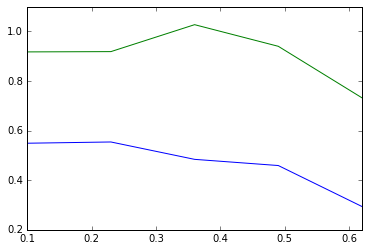

In [163]:
final_video_results['visual_weights'].plot()
combined_results['w_v'].plot()

### Apply to our data - combined

In [172]:
all_participants_combined = []
for filename in os.listdir('data/preprocessed/combined'):
    if filename.endswith('.p'):
        print(filename)
        data = pickle.load( open('data/preprocessed/combined/' + filename, "rb" ) )
        for noise in data.keys():
            data_here = data[noise]
            print(data_here.shape)
            try:
                results = compute_MLE_2(data_here)
                results['noise'] = noise
                results['participant'] = filename[:-2]
            except:
                print('problem occured')
                continue
                

            all_participants_combined.append(results)

participant1.p
(2, 70)
problem occured
(2, 70)
problem occured
(2, 70)
problem occured
(2, 70)
problem occured
(2, 70)
problem occured
participant10.p
(2, 70)
problem occured
(2, 70)
problem occured
(2, 70)
problem occured
(2, 70)
problem occured
(2, 70)
problem occured
participant11.p
(2, 70)
problem occured
(2, 70)
problem occured
(2, 70)
problem occured
(2, 70)
problem occured
(2, 70)
problem occured
participant12.p
(2, 70)
problem occured
(2, 70)
problem occured
(2, 70)
problem occured
(2, 70)
problem occured
(2, 70)
problem occured
participant13.p
(2, 70)
problem occured
(2, 70)
problem occured
(2, 70)
problem occured
(2, 70)
problem occured
(2, 70)
problem occured
participant14.p
(2, 70)
problem occured
(2, 70)
problem occured
(2, 70)
problem occured
(2, 70)
problem occured
(2, 70)
problem occured
participant15.p
(2, 70)
problem occured
(2, 70)
problem occured
(2, 70)
problem occured
(2, 70)
problem occured
(2, 70)
problem occured
Participant16.p
(2, 70)
problem occured
(2, 70)
p

In [171]:
combined_results = pd.DataFrame(all_participants_combined)
#.groupby('noise').mean()
combined_results

NameError: name 'all_participants_combined' is not defined

In [ ]:
final_video_results['visual_weights'].plot()
combined_results['w_a'].plot()

In [281]:
all_participants_combined

[{'noise': 0.1,
  'participant': 'participant1',
  'tau': 1.0,
  'w_a': 0.20000000000000001},
 {'noise': 0.23,
  'participant': 'participant1',
  'tau': 1.0,
  'w_a': 0.20000000000000001},
 {'noise': 0.62,
  'participant': 'participant1',
  'tau': 1.0,
  'w_a': 0.20000000000000001},
 {'noise': 0.49,
  'participant': 'participant1',
  'tau': 1.0,
  'w_a': 0.20000000000000001},
 {'noise': 0.36,
  'participant': 'participant1',
  'tau': 1.0,
  'w_a': 0.20000000000000001},
 {'noise': 0.1,
  'participant': 'participant10',
  'tau': 1.0,
  'w_a': 0.20000000000000001},
 {'noise': 0.23,
  'participant': 'participant10',
  'tau': 1.0,
  'w_a': 0.20000000000000001},
 {'noise': 0.62,
  'participant': 'participant10',
  'tau': 1.0,
  'w_a': 0.20000000000000001},
 {'noise': 0.49,
  'participant': 'participant10',
  'tau': 1.0,
  'w_a': 0.20000000000000001},
 {'noise': 0.36,
  'participant': 'participant10',
  'tau': 1.0,
  'w_a': 0.20000000000000001},
 {'noise': 0.1,
  'participant': 'participant2'